# sf work assignment.6.8.2016: Part I: Data cleaning and preparation
Frank Wang

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
#workingdirect='kaggle\Liberty_Mutual_fireloss_prediction\data'
read_all=1
num_data=200000
if read_all==1:
    train_data=pd.read_csv('../data/Data for Cleaning & Modeling.csv',sep=',',header=0)    
else:
    train_data=pd.read_csv('../data/Data for Cleaning & Modeling.csv',sep=',',header=0,\
                            nrows=num_data)
test_data=pd.read_csv('../data/Holdout for Testing.csv',sep=',',header=0)
num_train=len(train_data)
num_test=len(test_data)
#features_name=train_data.columns
print('total train data={}'.format(len(train_data)))
print('total test data={}'.format(len(test_data)))

total train data=400000
total test data=80000


C:\Users\wanglf\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
features_names=['rate','loanID','borrowerID','loanReq','loanFund','investFrac', \
               'numPayment','grade','subGrade','employer','yearsEmployed','homeOwner',\
                'income','incomeVeri','dateLoan','reason','category','loanTitle',
                'zipcode','state','debtRatio','dueNum','dateCreditOpen','numInquiry',\
               'monthsDelinquency','monthsRecord','numOpenCredit','numDerogatory',\
               'creditBalance','debt2limitRatio','numTotalCredit','listStatus']
train_data.columns=features_names
test_data.columns=features_names

# data type convert:
convert percentage into faction; date to number of years;
rate to number; dollar amount to float

In [4]:
from re import sub
from decimal import Decimal
def dollarString2float(string):
    '''
    Remove dollar sign from the string and return the number.
    Return -999 if there is a missing value.
    @param: raw string
    @return: number
    '''
    string=str(string)
    if string[0]!='$':
        return -999
    else:
        return float(Decimal(sub(r'[^\d.]', '', string)))
def monthString2float(string):
    '''
    Remove month from the string and return the number.
    Return -999 if there is a missing value.
    @param: raw string
    @return: number
    '''
    string=str(string)
    tmp=re.findall(r'\d\d.', string)
    if tmp:
        return float(Decimal(sub(r'[^\d.]', '', string)))
    else:
        return -999
def rateString2float(string):
    '''
    Remove % sign from the string and return the number.
    @param: raw string
    @return: number
    '''
    string=str(string)
    return (float(string.strip('%')))

In [5]:
def employyear_String2float(string):
    '''
    Remove "<,years,+" from the string and return the number.
    Return -999 if there is a missing value.
    @param: raw string
    @return: number
    '''
    string=str(string)
    string=string.strip('years').strip().strip('<').strip('+').strip('\n').strip('n/')
    if len(string)>0:
        try:
            aa=float(string)
        except ValueError:
            aa=-999
        return aa
    else:
        return -999

In [6]:
from datetime import datetime, timedelta
def mon_year2months(datestring):
    '''
    convert date type "Jun-09" from the string and return the number.
    Return -999 if there is a missing value.
    @param: raw string
    @return: number of years from that date to today, 2016-07-07
    the function name "2month" is kind of missleading, since oroginally it return month in stead of year;
    we keep like this.
    '''
    datestring=str(datestring)
    tmp=re.findall('\w\w\w', datestring)
    if tmp:
        monthdate=tmp[0]
        if len(monthdate)!=3:
            return -999
    else:
        return -999    
    tmp=re.findall('\d+',datestring)
    if tmp:
        yeardate=tmp[0]
        if len(yeardate)!=2:
            return -999
    else:
        return -999
    if int(yeardate)<16:
        yeardate='20'+yeardate     
    else:
        yeardate='19'+yeardate
    monthd1=datetime.strptime(monthdate, '%b').month
    day1='1'
    string_date=yeardate+'-'+str(monthd1)+'-'+day1
    date_object = datetime.strptime(string_date, '%Y-%m-%d')
    datetime_now= datetime.strptime('2016-07-07', '%Y-%m-%d')
    dt=datetime_now-date_object
    return (dt.days/365.0)

In [7]:
def transform_data(df):
    '''
    Clean the input pandas dataframe using functions defined previously
    @param: pandas dataframe
    @return: pandas dataframe
    '''
    df.loanReq=df.loanReq.apply(dollarString2float)
    df.loanFund=df.loanFund.apply(dollarString2float)
    df.investFrac=df.investFrac.apply(dollarString2float)
    df.numPayment=df.numPayment.apply(monthString2float)
    df.dateCreditOpen=df.dateCreditOpen.apply(mon_year2months)
    df.dateLoan=df.dateLoan.apply(mon_year2months)
    df.rate=df.rate.apply(rateString2float)
    df.debt2limitRatio=df.debt2limitRatio.apply(rateString2float)*0.01
    df.yearsEmployed=df.yearsEmployed.apply(employyear_String2float)

In [8]:
transform_data(train_data)
transform_data(test_data)
train_data=train_data.replace(-999.000,np.nan)
print 'data transform done'

data transform done


# feature  engineer

###### check whether there are repeated data

In [10]:
if len(set(train_data.loanID))!=len(train_data.loanID):
    print ('some repeat ID found')
if len(set(train_data.borrowerID))!=len(train_data.borrowerID):
    print ('some repeat borroweID found')

###### drop rows with missing rate (response)

In [11]:
train_data=train_data[train_data.rate.notnull()]

###### drop non-important features for regression

In [12]:
num_miss_col=np.sum(train_data.isnull())
num_miss_row=np.sum(train_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))

number of missing col=rate                      0
loanID                    1
borrowerID                1
loanReq                   1
loanFund                  1
investFrac                1
numPayment                1
grade                 51867
subGrade              51867
employer              20253
yearsEmployed         14795
homeOwner             51960
income                51752
incomeVeri                1
dateLoan                  1
reason               233933
category                  1
loanTitle                16
zipcode                   1
state                     1
debtRatio                 1
dueNum                    1
dateCreditOpen            1
numInquiry                1
monthsDelinquency    185457
monthsRecord         295590
numOpenCredit             1
numDerogatory             1
creditBalance             1
debt2limitRatio         225
numTotalCredit            1
listStatus                1
dtype: int64
number of missing row=336073


In [13]:
feature_missing=[]
for (it,feature) in enumerate(features_names):
    if (num_miss_col[it]>num_train*0.5):
        feature_missing.append(feature)
        print ('feature {} has more than 50% missing'.format(feature))

feature reason has more than 50% missing
feature monthsRecord has more than 50% missing


#### features drop/convert based on preliminary study
(0)drop rows with missing rate
(1)convert loanReq to ratio=loanReq/loanFund or drop;
   normlize investFfrac by loanFund
(2)drop income?
(3)convert numpayment to category,1,2
(4)drop grade and convert subGrade to category or numeric==mean rate of each category
(5)drop numTotalCredit

In [14]:
# drop rows with small number missing in feature
for (it,feature) in enumerate(train_data.columns):
    if (num_miss_col[it]<num_train*0.05):
        train_data=train_data[train_data.iloc[:,it].notnull()]
        print ('drop rows: feature {} has {} missing'.format(feature,num_miss_col[it]))       

drop rows: feature rate has 0 missing
drop rows: feature loanID has 1 missing
drop rows: feature borrowerID has 1 missing
drop rows: feature loanReq has 1 missing
drop rows: feature loanFund has 1 missing
drop rows: feature investFrac has 1 missing
drop rows: feature numPayment has 1 missing
drop rows: feature yearsEmployed has 14795 missing
drop rows: feature incomeVeri has 1 missing
drop rows: feature dateLoan has 1 missing
drop rows: feature category has 1 missing
drop rows: feature loanTitle has 16 missing
drop rows: feature zipcode has 1 missing
drop rows: feature state has 1 missing
drop rows: feature debtRatio has 1 missing
drop rows: feature dueNum has 1 missing
drop rows: feature dateCreditOpen has 1 missing
drop rows: feature numInquiry has 1 missing
drop rows: feature numOpenCredit has 1 missing
drop rows: feature numDerogatory has 1 missing
drop rows: feature creditBalance has 1 missing
drop rows: feature debt2limitRatio has 225 missing
drop rows: feature numTotalCredit has

In [15]:
train_data=train_data[train_data.subGrade.notnull()]

In [16]:
# rare event, not in test
state_drop=['IA','ID','ME','NE']
train_data=train_data[train_data.state != state_drop[0]]
train_data=train_data[train_data.state != state_drop[1]]
train_data=train_data[train_data.state != state_drop[2]]
train_data=train_data[train_data.state != state_drop[3]]

In [17]:
#rare event, not in test
owner_keep=['MORTGAGE','OWN','RENT']
owner_drop=['ANY','NONE','OTHER'] 
train_data=train_data[train_data.homeOwner != owner_drop[0]]
train_data=train_data[train_data.homeOwner != owner_drop[1]]
train_data=train_data[train_data.homeOwner != owner_drop[2]]

###### New features

In [19]:
train_data.openCreditLineRatio=train_data.numOpenCredit/train_data.numTotalCredit
train_data.amountPayPerMonth=train_data.loanFund/train_data.numPayment
train_data.loan2balance=train_data.loanFund/train_data.creditBalance
train_data.loan2income=train_data.loanFund/train_data.income

test_data.openCreditLineRatio=test_data.numOpenCredit/train_data.numTotalCredit
test_data.amountPayPerMonth=test_data.loanFund/train_data.numPayment
test_data.loan2balance=test_data.loanFund/train_data.creditBalance
test_data.loan2income=test_data.loanFund/train_data.income

In [20]:
fearures_new=['openCreditLineRatio','amountPayPerMonth','loan2balance','loan2income']

In [21]:
train_data.loanReq=train_data.loanFund/train_data.loanReq
train_data.investFrac=train_data.investFrac/train_data.loanFund
test_data.loanReq=test_data.loanFund/test_data.loanReq
test_data.investFrac=test_data.investFrac/test_data.loanFund

In [27]:
print len(train_data.columns)
print len(test_data.columns)

71
70


In [41]:
test_data.iloc[0:5,60:]

,category_home_improvement,category_house,category_major_purchase,category_medical,category_moving,category_other,category_renewable_energy,category_small_business,category_vacation,category_wedding
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [42]:
train_data.iloc[0:5,60:]

,category_educational,category_home_improvement,category_house,category_major_purchase,category_medical,category_moving,category_other,category_renewable_energy,category_small_business,category_vacation,category_wedding
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# category to dummy varibles
category_features=['subGrade','numPayment','homeOwner','category']

for feature in category_features:
    tmp_feature=pd.get_dummies(train_data[feature],prefix=feature)
    train_data = pd.concat([train_data, tmp_feature], axis=1)
    tmp_feature1=pd.get_dummies(test_data[feature],prefix=feature)
    test_data = pd.concat([test_data, tmp_feature1], axis=1)
train_data=train_data.drop(category_features,axis=1)
test_data=test_data.drop(category_features,axis=1)

In [25]:
drop_features=['employer','zipcode','incomeVeri','loanTitle','reason','grade']
drop_features2=['yearsEmployed','numDerogatory','state','listStatus']
drop_features=drop_features+feature_missing+drop_features2
train_data=train_data.drop(drop_features,axis=1)
test_data=test_data.drop(drop_features,axis=1)

###### missing filling

In [26]:
for x in train_data.columns:
    if (train_data[x].dtype==float):
        train_data[x].fillna(train_data[x].mean(),inplace=True)
for x in test_data.columns:
    if (test_data[x].dtype==float):
        test_data[x].fillna(test_data[x].mean(),inplace=True)

In [31]:
test_data=test_data.drop('rate',axis=1)
test_data.to_csv('featured_Test.csv',sep=',',index=False)
train_data.to_csv('featured_Train.csv',sep=',',index=False)

In [26]:
train_data.head(5)

,rate,loanID,borrowerID,loanReq,loanFund,investFrac,income,dateLoan,debtRatio,dueNum,...,category_home_improvement,category_house,category_major_purchase,category_medical,category_moving,category_other,category_renewable_energy,category_small_business,category_vacation,category_wedding
0,11.89,54734,80364,1,25000,0.763200,85000,6.936986,19.48,0,...,0,0,0,0,0,0,0,0,0,0
1,10.71,55742,114426,1,7000,0.096143,65000,8.189041,14.29,0,...,0,0,0,0,0,0,0,0,0,0
2,16.99,57167,137225,1,25000,0.989000,70000,1.934247,10.50,0,...,0,0,0,0,0,0,0,0,0,0
3,13.11,57245,138150,1,1200,1.000000,54000,6.356164,5.47,0,...,0,0,0,0,0,0,0,0,0,0
4,13.57,57416,139635,1,10800,0.990000,32000,6.684932,11.63,0,...,0,0,0,0,0,0,0,0,0,0


# End of feature study
the folllowings are some plots/tables only

In [29]:
num_miss_col=np.sum(train_data.isnull())
num_miss_row=np.sum(train_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))
print ('number of total data={}'.format(len(train_data)))

number of missing col=rate                           0
loanID                         0
borrowerID                     0
loanReq                        0
loanFund                       0
investFrac                     0
income                         0
dateLoan                       0
debtRatio                      0
dueNum                         0
dateCreditOpen                 0
numInquiry                     0
monthsDelinquency              0
numOpenCredit                  0
creditBalance                  0
debt2limitRatio                0
numTotalCredit                 0
subGrade_A1                    0
subGrade_A2                    0
subGrade_A3                    0
subGrade_A4                    0
subGrade_A5                    0
subGrade_B1                    0
subGrade_B2                    0
subGrade_B3                    0
subGrade_B4                    0
subGrade_B5                    0
subGrade_C1                    0
subGrade_C2                    0
subGrade_C3          

In [34]:
print len(train_data.columns)
print len(test_data.columns)

71
69


In [32]:
num_miss_col=np.sum(test_data.isnull())
num_miss_row=np.sum(test_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))
print ('number of total data={}'.format(len(test_data)))

number of missing col=loanID                         0
borrowerID                     0
loanReq                        0
loanFund                       0
investFrac                     0
income                         0
dateLoan                       0
debtRatio                      0
dueNum                         0
dateCreditOpen                 0
numInquiry                     0
monthsDelinquency              0
numOpenCredit                  0
creditBalance                  0
debt2limitRatio                0
numTotalCredit                 0
subGrade_A1                    0
subGrade_A2                    0
subGrade_A3                    0
subGrade_A4                    0
subGrade_A5                    0
subGrade_B1                    0
subGrade_B2                    0
subGrade_B3                    0
subGrade_B4                    0
subGrade_B5                    0
subGrade_C1                    0
subGrade_C2                    0
subGrade_C3                    0
subGrade_C4          

# visualization of data

In [24]:
def group_plot(feature,xlab=0,font=10,axis=0):
    StateGroup=train_data.groupby([feature]).mean()
    my_xticks = StateGroup.index
    x= np.arange(len(my_xticks))
    x2=x+0.5
    f, axs = plt.subplots(1,2,figsize=(15,5))
    plt.subplot(1,2,1)
#   fig=plt.figure()
    if axis==0:
        rot='horizontal'
    else:
        rot='vertical'
#     if xlab==0:
#         plt.bar(StateGroup['rate'].values)        
#     else:
    plt.bar(x,StateGroup['rate'].values)
#    plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
    plt.xticks(x2, my_xticks,fontsize = font,rotation=rot)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.xlabel(feature,fontsize=25)
    plt.ylabel('mean rate (%)',fontsize=25)
    fig.set_size_inches(10,6) 
    plt.title('Mean Rate of '+feature,fontsize=20)
    
    plt.subplot(1,2,2)
    data=train_data[feature]
    density = stats.kde.gaussian_kde(data)
    peak=max(data)
    steps=peak/100.0
    x = np.arange(0., peak, steps)
    plt.plot(x, density(x))
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.xlabel(feature,fontsize=25)
    plt.ylabel('density',fontsize=25)
    plt.title(feature,fontsize=20)

In [42]:
def corr_rate_plot(feature,nbins=20):
    peak=max(train_data[feature])
    low=min(train_data[feature])
    step=(peak-low)/nbins
#    x = np.arange(low, peak, step)
    x=np.arange(nbins)
    x=x*step+low
    density=np.zeros(nbins)
    num_cel=np.ones(nbins)    
    for (i,zz) in enumerate(train_data[feature]):
#       zz=train_data[feature][i]
        if np.isnan(zz):
            continue
        else:
            icel=int((zz-low)/step)
            cof=1.0
            if icel<0 or icel>=nbins:
                icel=nbins-1
                cof=0.0
            j=train_data.index[i]
            num_cel[icel]=num_cel[icel]+1
            density[icel]=density[icel]+cof*train_data['rate'][j]
    plt.plot(x,density/num_cel)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.xlabel(feature,fontsize=25)
    plt.ylabel('mean rate (%)',fontsize=25)
    plt.title(feature,fontsize=20)

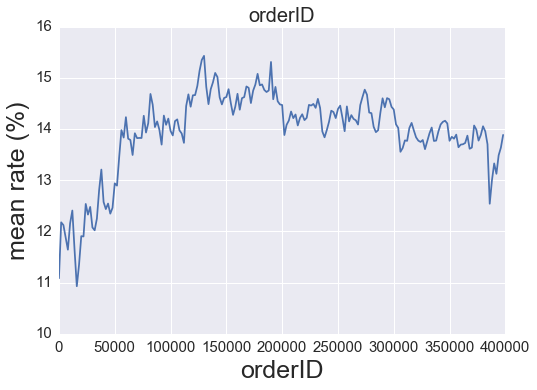

In [77]:
#train_data['orderID']=train_data.index
#train_data=1.0*train_data_cp
corr_rate_plot('orderID',nbins=200)

In [45]:
train_data.head()

,rate,loanID,borrowerID,loanReq,loanFund,investFrac,income,dateLoan,category,state,...,subGrade_G1,subGrade_G2,subGrade_G3,subGrade_G4,subGrade_G5,numPayment_36.0,numPayment_60.0,homeOwner_MORTGAGE,homeOwner_OWN,homeOwner_RENT
33,13.75,87023,86999,1,7500,0.106667,22000,9.106849,debt_consolidation,MA,...,0,0,0,0,0,1,0,0,1,0
36,8.07,90395,90390,1,5000,0.265000,100000,9.024658,debt_consolidation,MA,...,0,0,0,0,0,1,0,1,0,0
45,9.33,92666,92661,1,5000,0.105000,180000,9.024658,home_improvement,WI,...,0,0,0,0,0,1,0,1,0,0
51,8.38,96844,95222,1,5300,0.113208,74000,9.024658,credit_card,IN,...,0,0,0,0,0,1,0,1,0,0
50,11.22,96350,96338,1,5000,0.170000,30000,9.024658,credit_card,GA,...,0,0,0,0,0,1,0,0,1,0


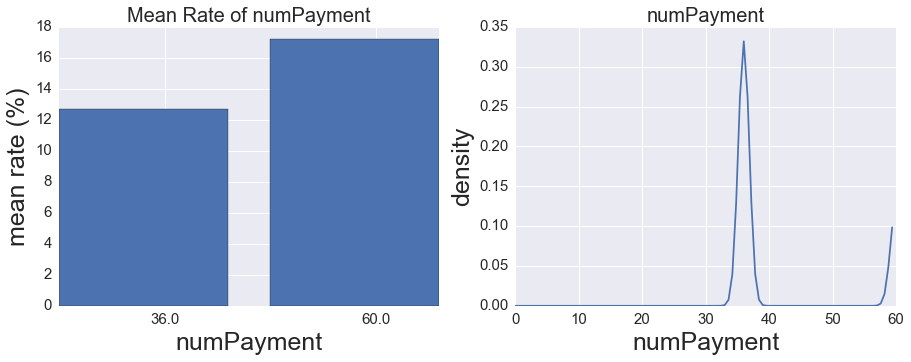

In [465]:
group_plot('numPayment')

TypeError: unsupported operand type(s) for /: 'str' and 'long'

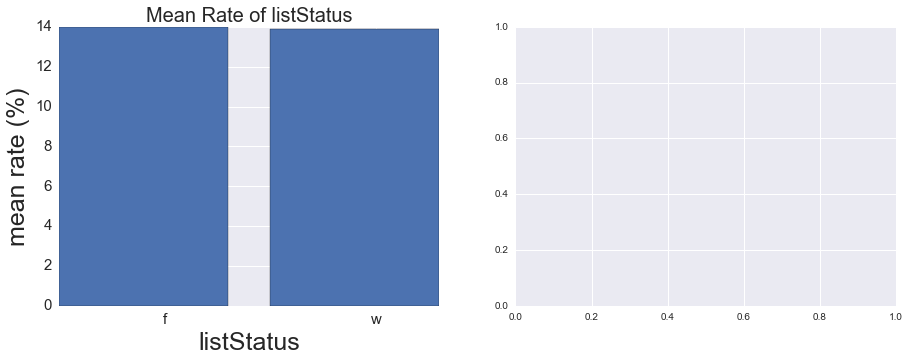

In [466]:
group_plot('listStatus')

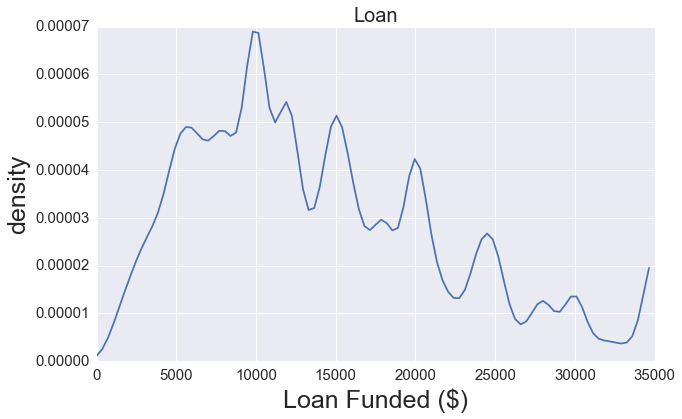

In [428]:
#plt.scatter(train_data.loanFund,train_data.rate)

data=train_data.loanFund
density = stats.kde.gaussian_kde(data)
peak=max(data)
steps=peak/100.0
x = np.arange(0., peak, steps)

fig=plt.figure()
plt.plot(x, density(x))
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Loan Funded ($)',fontsize=25)
plt.ylabel('density',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Loan',fontsize=20)

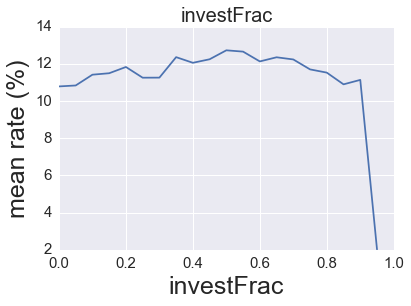

In [576]:
corr_rate_plot('investFrac',nbins=20)

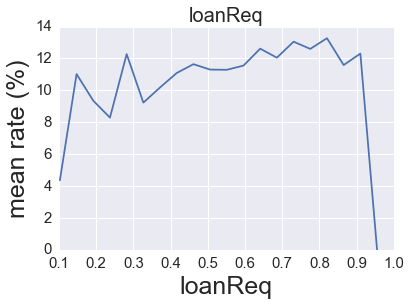

In [575]:
#plt.scatter(train_data.loanReq[1:10000],train_data.rate[1:10000])
corr_rate_plot('loanReq',nbins=20)

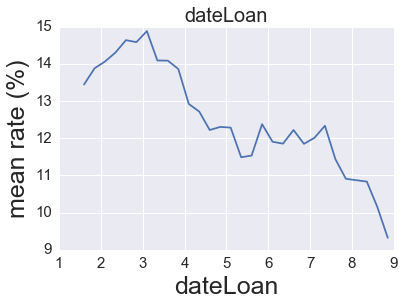

In [574]:
#plt.scatter(train_data.dateLoan,train_data.rate)
corr_rate_plot('dateLoan',nbins=30)

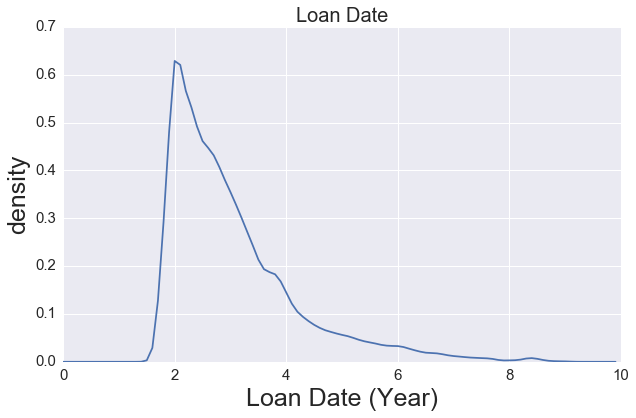

In [419]:
# plt.hist(train_data.dateLoan,bins=100)
# plt.hist(test_data.dateLoan,bins=100)
data=train_data.dateLoan
density = stats.kde.gaussian_kde(data)
x = np.arange(0., 10, .1)

fig=plt.figure()
plt.plot(x, density(x))
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Loan Date (Year)',fontsize=25)
plt.ylabel('density',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Loan Date',fontsize=20)

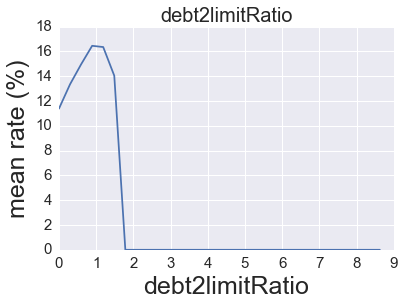

In [582]:

#plt.scatter(train_data.debt2limitRatio[1:20000],train_data.rate[1:20000])
corr_rate_plot('debt2limitRatio',nbins=30)

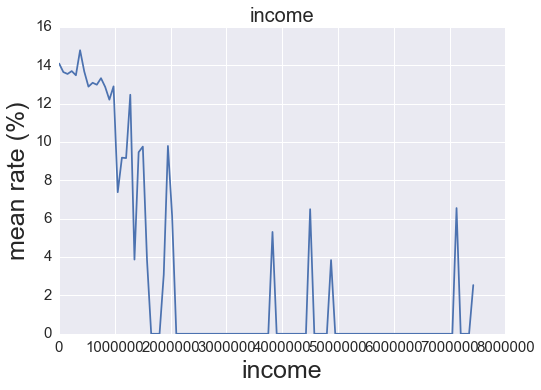

In [28]:
# plt.scatter(train_data.income[1:20000],train_data.rate[1:20000])
# plt.xlim([0,200000])
corr_rate_plot('income',nbins=100)

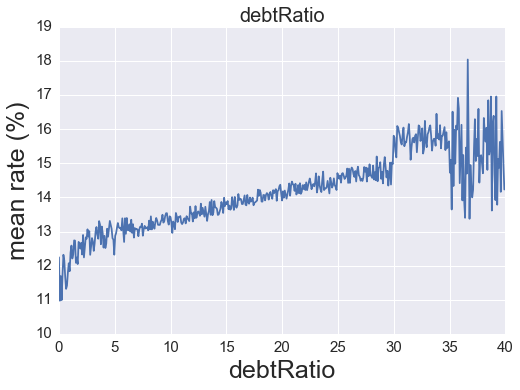

In [26]:
# plt.scatter(train_data.debtRatio[1:20000],train_data.rate[1:20000])
# plt.xlim([0,30])
# plt.ylim([5,20])
corr_rate_plot('debtRatio',nbins=500)

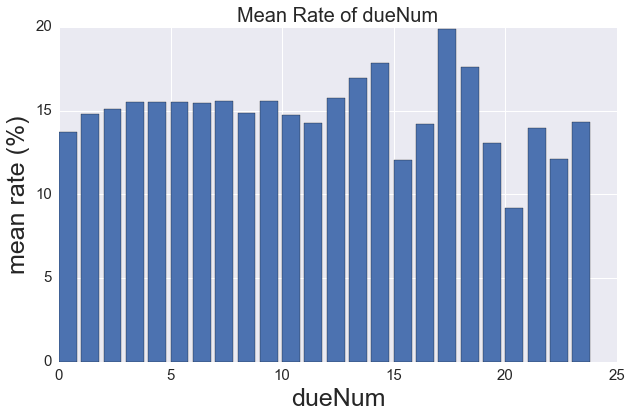

In [412]:

#plt.scatter(train_data.dueNum[1:20000],train_data.rate[1:20000])
StateGroup=train_data.groupby(['dueNum']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
#plt.xticks(x2, my_xticks,fontsize = 10,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('dueNum',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Mean Rate of dueNum',fontsize=20)

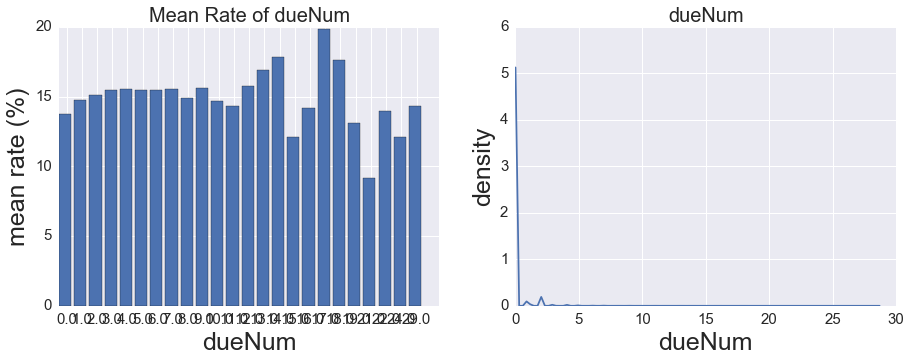

In [469]:
group_plot('dueNum',font=4)

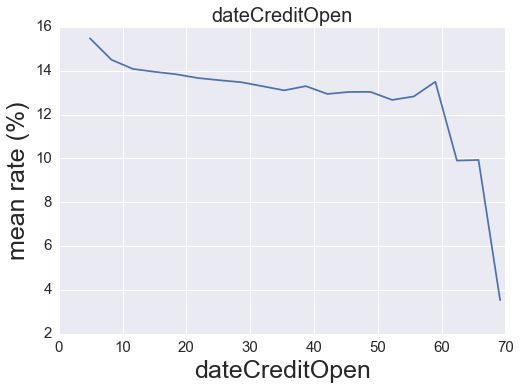

In [45]:

#plt.scatter(train_data.dateCreditOpen[1:20000],train_data.rate[1:20000])
#sns.jointplot(x="dateCreditOpen", y="rate", data=train_data, kind="kde");
corr_rate_plot('dateCreditOpen',nbins=20)

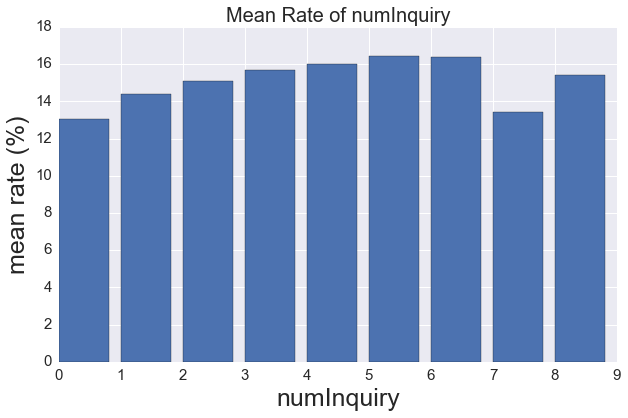

In [410]:
 
#plt.scatter(train_data.numInquiry[1:20000],train_data.rate[1:20000])
StateGroup=train_data.groupby(['numInquiry']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
#plt.xticks(x2, my_xticks,fontsize = 10,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('numInquiry',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Mean Rate of numInquiry',fontsize=20)

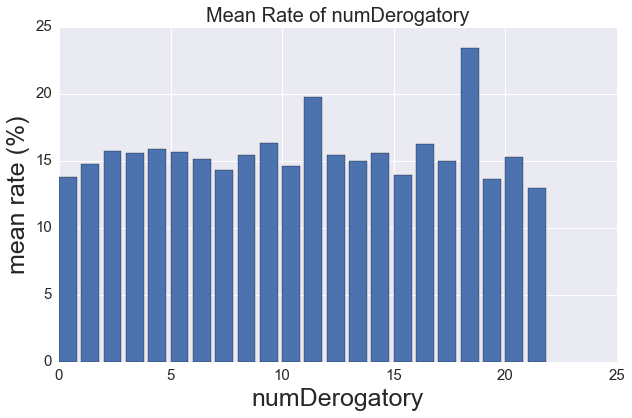

In [424]:
# numDerogatory
#plt.scatter(train_data.numDerogatory[1:40000],train_data.rate[1:40000])
StateGroup=train_data.groupby(['numDerogatory']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
#plt.xticks(x2, my_xticks,fontsize = 10,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('numDerogatory',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Mean Rate of numDerogatory',fontsize=20)

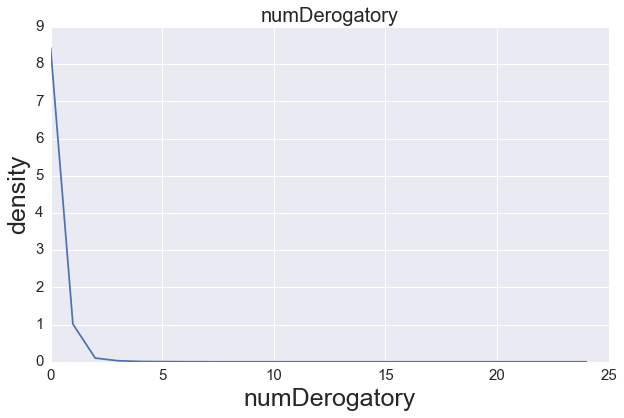

In [425]:
data=train_data.numDerogatory
density = stats.kde.gaussian_kde(data)
x = np.arange(0., 25, 1)

fig=plt.figure()
plt.plot(x, density(x))
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('numDerogatory',fontsize=25)
plt.ylabel('density',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('numDerogatory',fontsize=20)

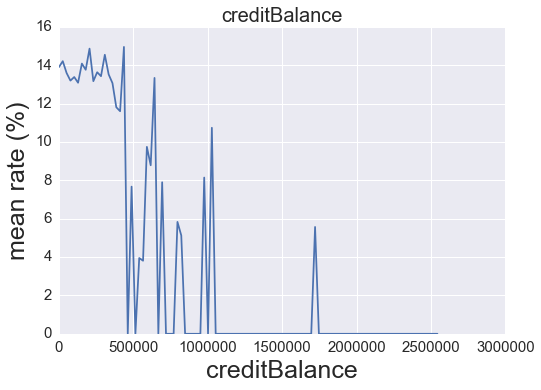

In [30]:
corr_rate_plot('creditBalance',nbins=100)

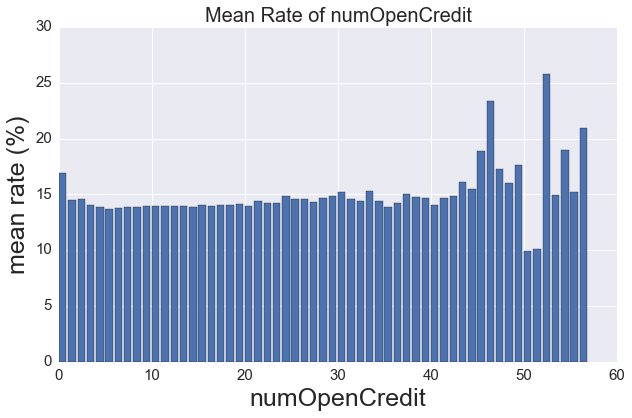

In [408]:
#plt.scatter(train_data.numOpenCredit[1:20000],train_data.rate[1:20000])
StateGroup=train_data.groupby(['numOpenCredit']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
#plt.xticks(x2, my_xticks,fontsize = 10,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('numOpenCredit',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Mean Rate of numOpenCredit',fontsize=20)

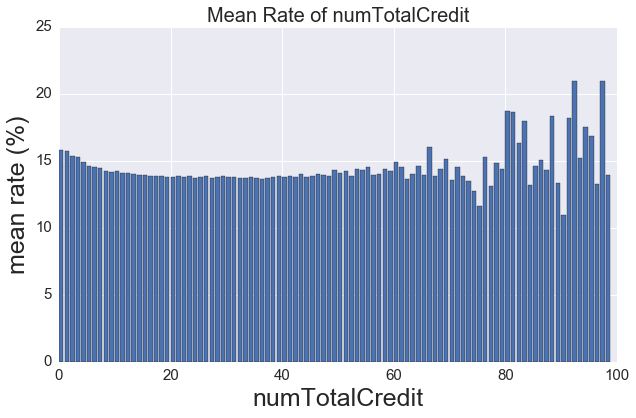

In [407]:
# numTotalCredit 
#plt.scatter(train_data.numTotalCredit[1:20000],train_data.rate[1:20000])
StateGroup=train_data.groupby(['numTotalCredit']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
#plt.xticks(x2, my_xticks,fontsize = 10,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('numTotalCredit',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(10,6) 
plt.title('Mean Rate of numTotalCredit',fontsize=20)

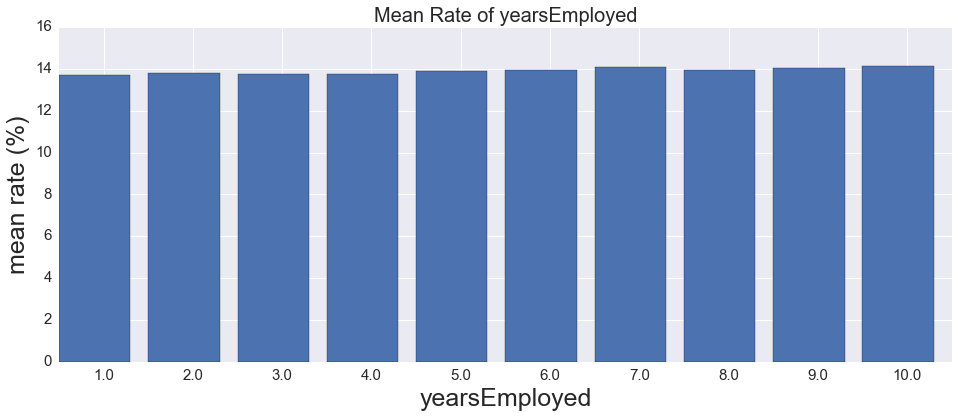

In [395]:
#plt.scatter(train_data.yearsEmployed[1:20000],train_data.rate[1:20000])
StateGroup=train_data.groupby(['yearsEmployed']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
plt.xticks(x2, my_xticks,fontsize = 15,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xlabel('yearsEmployed',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(16,6) 
plt.title('Mean Rate of yearsEmployed',fontsize=20)

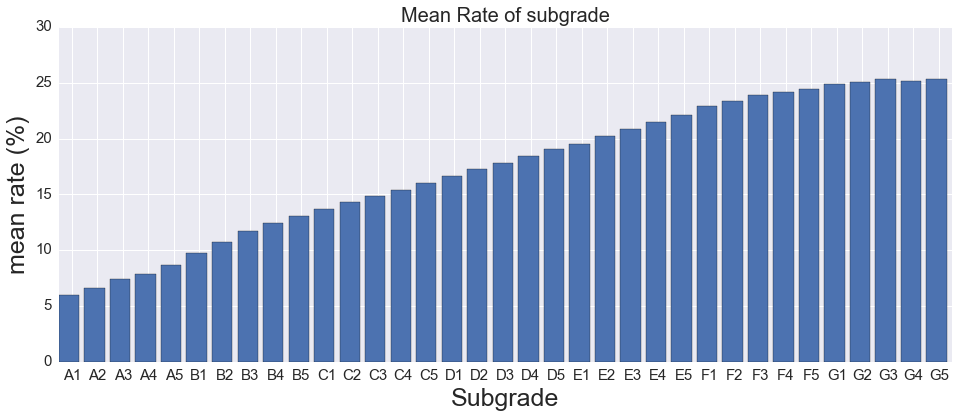

In [393]:
#train_data.groupby('subGrade').count()
StateGroup=train_data.groupby(['subGrade']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
#plt.xticks(x, my_xticks,fontsize = 15,rotation='vertical')
plt.xticks(x2, my_xticks,fontsize = 15,rotation='horizontal')
plt.yticks(fontsize = 15)
plt.xlabel('Subgrade',fontsize=25)
plt.ylabel('mean rate (%)',fontsize=25)
fig.set_size_inches(16,6) 
plt.title('Mean Rate of subgrade',fontsize=20)


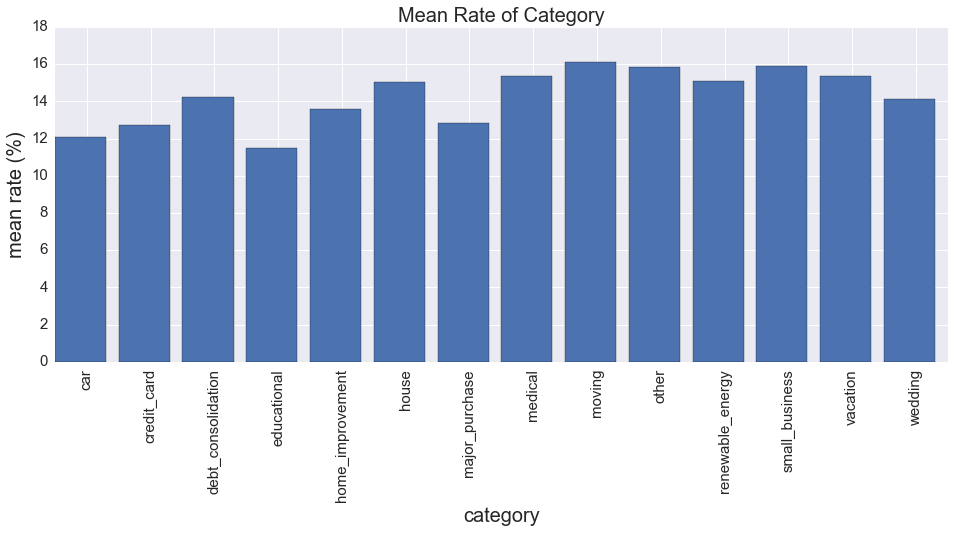

In [394]:
#train_data.groupby('category').mean()
StateGroup=train_data.groupby(['category']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
x2=x+0.5
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
plt.xticks(x2, my_xticks,fontsize = 15,rotation='vertical')
plt.yticks(fontsize=15)
plt.xlabel('category',fontsize=20)
plt.ylabel('mean rate (%)',fontsize=20)
fig.set_size_inches(16,6) 
plt.title('Mean Rate of Category',fontsize=20)


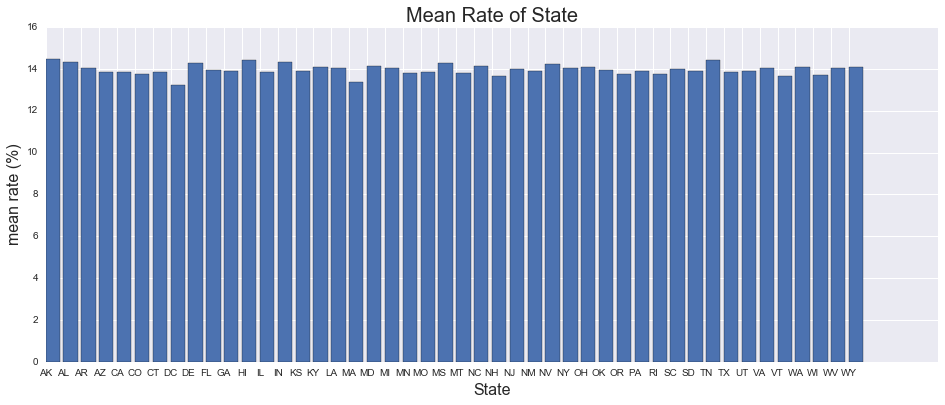

In [378]:
StateGroup=train_data.groupby(['state']).mean()
my_xticks = StateGroup.index
x= np.arange(len(my_xticks))
fig=plt.figure()
plt.bar(x,StateGroup['rate'].values)
plt.xticks(x, my_xticks)
plt.xlabel('State',fontsize=16)
plt.ylabel('mean rate (%)',fontsize=16)
fig.set_size_inches(16,6) 
plt.title('Mean Rate of State',fontsize=20)

In [258]:
train_data.groupby('homeOwner').mean()

,rate,loanReq,loanFund,investFrac,numPayment,yearsEmployed,income,debtRatio,dueNum,numInquiry,numDerogatory,creditBalance,debt2limitRatio,numTotalCredit
homeOwner,,,,,,,,,,,,,,
ANY,11.670000,1.000000,5000.000000,1.000000,36.000000,5.000000,35680.000000,28.120000,0.000000,0.000000,0.000000,3319.000000,0.431000,12.000000
MORTGAGE,13.659743,0.998296,16004.290841,0.994768,43.793725,6.760564,84254.392358,16.906011,0.316361,0.887091,0.146786,19189.875274,0.565497,27.646067
NONE,14.008276,1.000000,12698.275862,0.936948,38.482759,6.448276,65317.629630,17.636897,0.344828,0.620690,0.000000,15207.482759,0.564310,21.551724
OTHER,13.064519,0.968758,11321.875000,0.812253,37.153846,4.730769,67564.295455,13.897404,0.230769,0.971154,0.019231,13320.605769,0.534856,22.346154
OWN,14.103279,0.998945,13692.621116,0.995100,42.108478,6.253511,67393.480266,17.570816,0.268562,0.817799,0.150430,15786.116333,0.533358,24.296428
RENT,14.236348,0.998619,12466.876654,0.992470,41.070195,5.163436,63091.730047,16.856182,0.228823,0.732003,0.145844,12295.472734,0.568264,21.906365


In [18]:
test_data.groupby('homeOwner').count()

,rate,loanID,borrowerID,loanReq,loanFund,investFrac,numPayment,grade,subGrade,employer,...,dateCreditOpen,numInquiry,monthsDelinquency,monthsRecord,numOpenCredit,numDerogatory,creditBalance,debt2limitRatio,numTotalCredit,listStatus
homeOwner,,,,,,,,,,,,,,,,,,,,,
MORTGAGE,0,38994,38994,38994,38994,38994,38994,38994,38994,36994,...,38994,38994,21249,6595,38994,38994,38994,38980,38994,38994
OWN,0,8228,8228,8228,8228,8228,8228,8228,8228,7385,...,8228,8228,4229,1416,8228,8228,8228,8224,8228,8228
RENT,0,32778,32778,32778,32778,32778,32778,32778,32778,31227,...,32778,32778,15818,5828,32778,32778,32778,32766,32778,32778


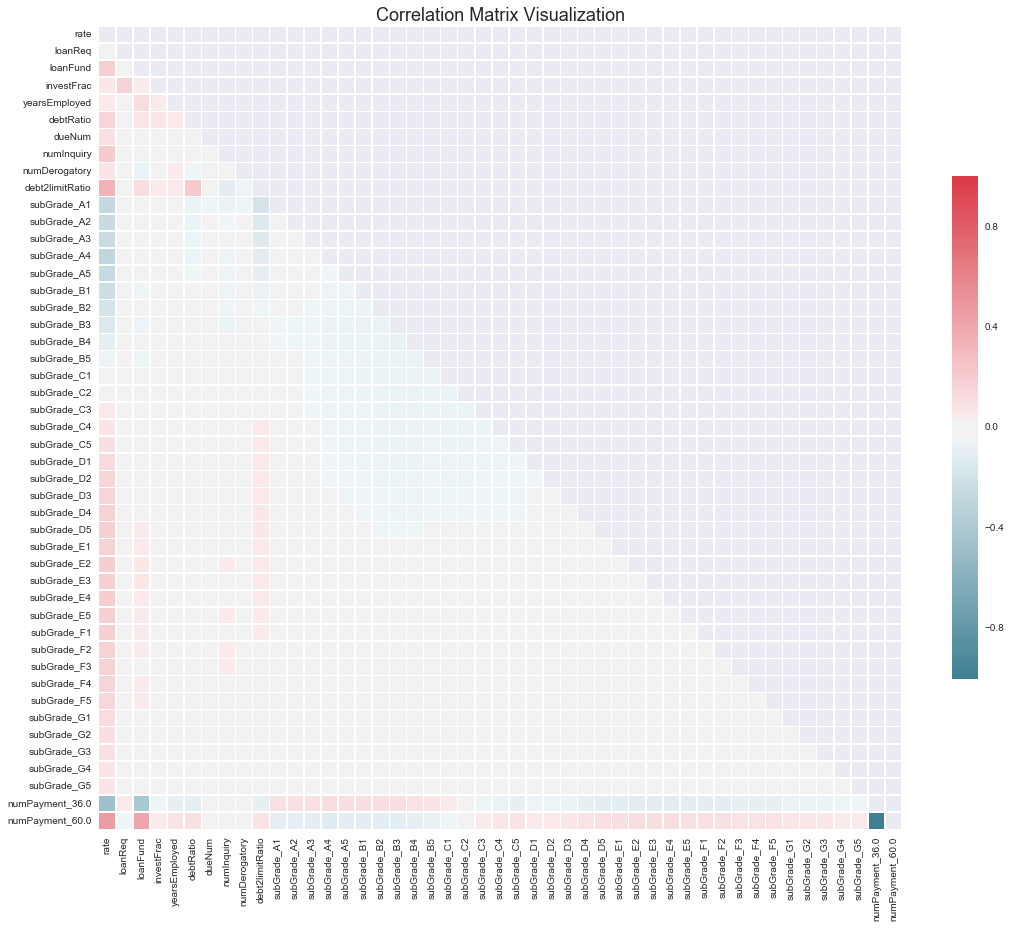

In [35]:
#xtrain_data.corr()
fig = plt.figure(figsize=(18,18))
corr= train_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,square=True,
#            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=2
# sns.graphics.plot_corr(corr_matrix, xnames=xtrain_data.names)
# plt.show()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix Visualization",fontsize=18)
fig.set_dpi(1240)
fig.savefig('corrplot.png', transparent=True, bbox_inches='tight', pad_inches=0)


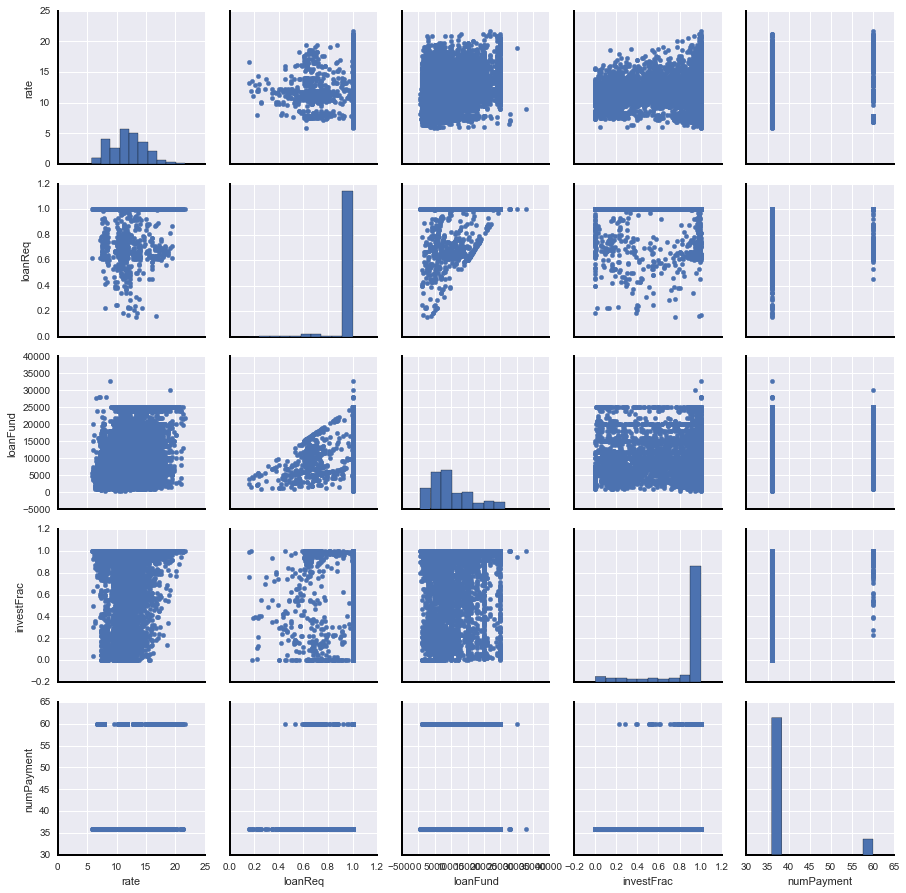

In [300]:
g = sns.PairGrid(train_data.iloc[0:10000,0:6])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

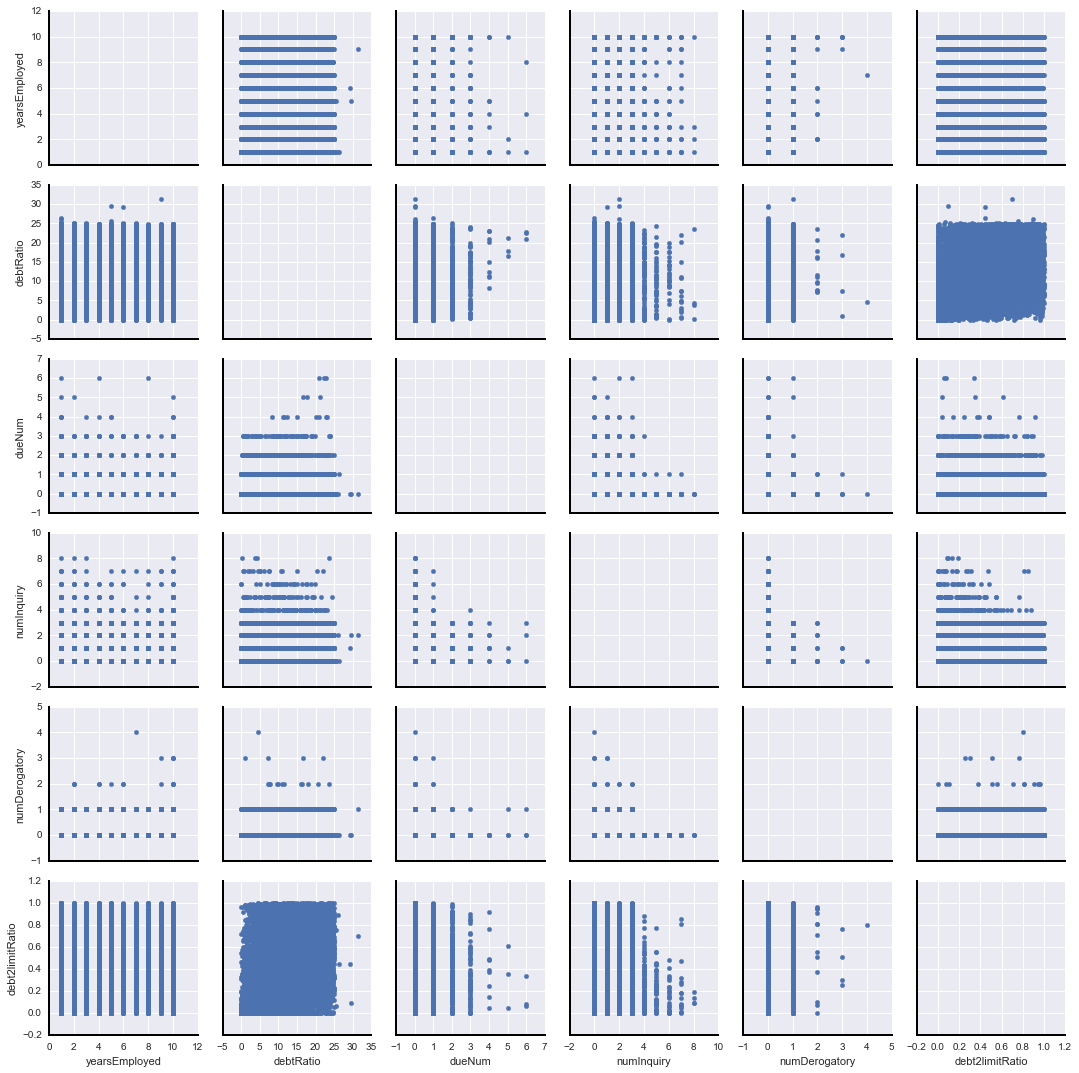

In [301]:
g = sns.PairGrid(train_data.iloc[0:10000,6:15])
#g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)